In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import geopandas as gpd
import json
import re

In [3]:
with open("./params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [4]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}
ordered_basins = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "NorthTyr", "WestMed"]

In [5]:
phyto_abund = pd.read_csv('./phyto_abund.csv')

In [6]:
phyto_abund["Basin"] = pd.Categorical(phyto_abund["Basin"], categories=ordered_basins, ordered=True)
phyto_abund["Region"] = pd.Categorical(phyto_abund["Region"], categories=list(from_region_to_abreviation.values()), ordered=True)

In [5]:
italy = gpd.read_file("./Italy_shp/Italy.shp")
surroundings = gpd.read_file("./Surrounding_shp/Surrounding.shp")
basins = gpd.read_file("./Basins_shp/Basins.shp")

In [7]:
basins_centers = basins.copy()
basins_centers["geometry"] = basins["geometry"].to_crs(3857).centroid.to_crs(basins.crs)
region_centers = italy.loc[italy["region"].isin(list(from_region_to_abreviation.keys())), :]
region_centers.loc[:, "geometry"] = italy.loc[italy["region"].isin(list(from_region_to_abreviation.keys())), "geometry"].to_crs(3857).centroid.to_crs(italy.crs);
region_centers.loc[:, "region"] = region_centers["region"].map(from_region_to_abreviation);

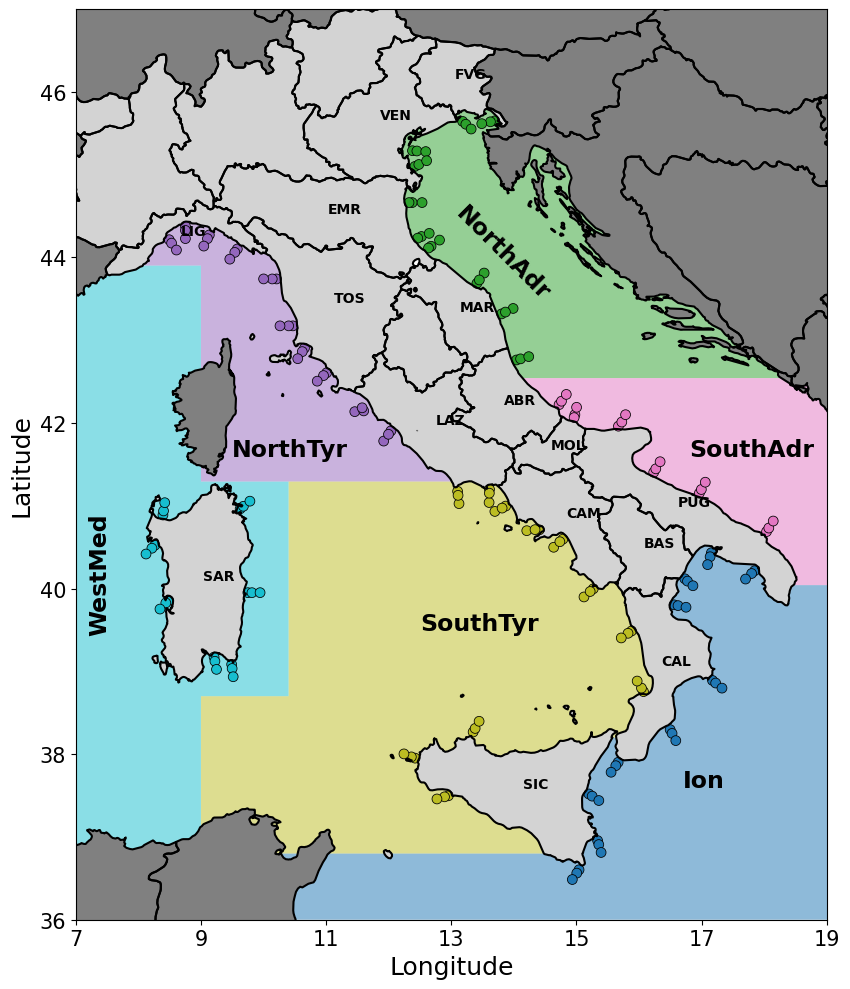

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

Basin_name_locations = {
    "NorthAdr" : [13, 43.5, -45], 
    "SouthAdr" : [16.8, 41.6, 0],
    "Ion" : [16.7, 37.6, 0],
    "SouthTyr" : [12.5, 39.5, 0],
    "NorthTyr" : [9.5, 41.6, 0],
    "WestMed" : [7.2, 39.5, 90],
}

colors = plt.get_cmap("tab10", basins["Basin"].size)
palette = dict(zip(basins["Basin"], colors.colors))
italy.boundary.plot(ax=ax, color='black')
surroundings.plot(ax = ax, color = "grey")
surroundings.boundary.plot(ax = ax, color = "black")
italy.plot(ax = ax, color = "lightgrey")
basins.plot("Basin",ax = ax, cmap = colors, alpha = 0.5)
for idx, row in region_centers.iterrows(): 
    ax.text(row["geometry"].x, row["geometry"].y, row["region"], fontsize=10, weight = "bold")
for basin_name, coord in Basin_name_locations.items(): 
    ax.text(coord[0], coord[1], basin_name, fontsize=17, weight = "bold", rotation = coord[2])
sns.scatterplot(data = phyto_abund.loc[:, ["Longitude", "Latitude", "Basin"]].drop_duplicates(), x = "Longitude", y = "Latitude", ax = ax, hue = "Basin", palette=palette, edgecolor = "black", s = 50, legend=False)
ax.set_xlabel("Longitude", size = 18)
ax.set_ylabel("Latitude", size = 18)
ax.set_xticks(np.arange(7,20,2), labels = np.arange(7,20,2).astype(str), size = 15)
ax.set_yticks(np.arange(36,47,2), labels = np.arange(36,47,2).astype(str), size = 15)
#ax.set_xticklabels(ax.get_xticklabels(), size = 12)
#ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_xlim(7,19)
ax.set_ylim(36,47)
plt.tight_layout()
fig.savefig("./Italy_map.png", dpi = 300, bbox_inches = "tight")

Text(0.5, 0, 'Region')

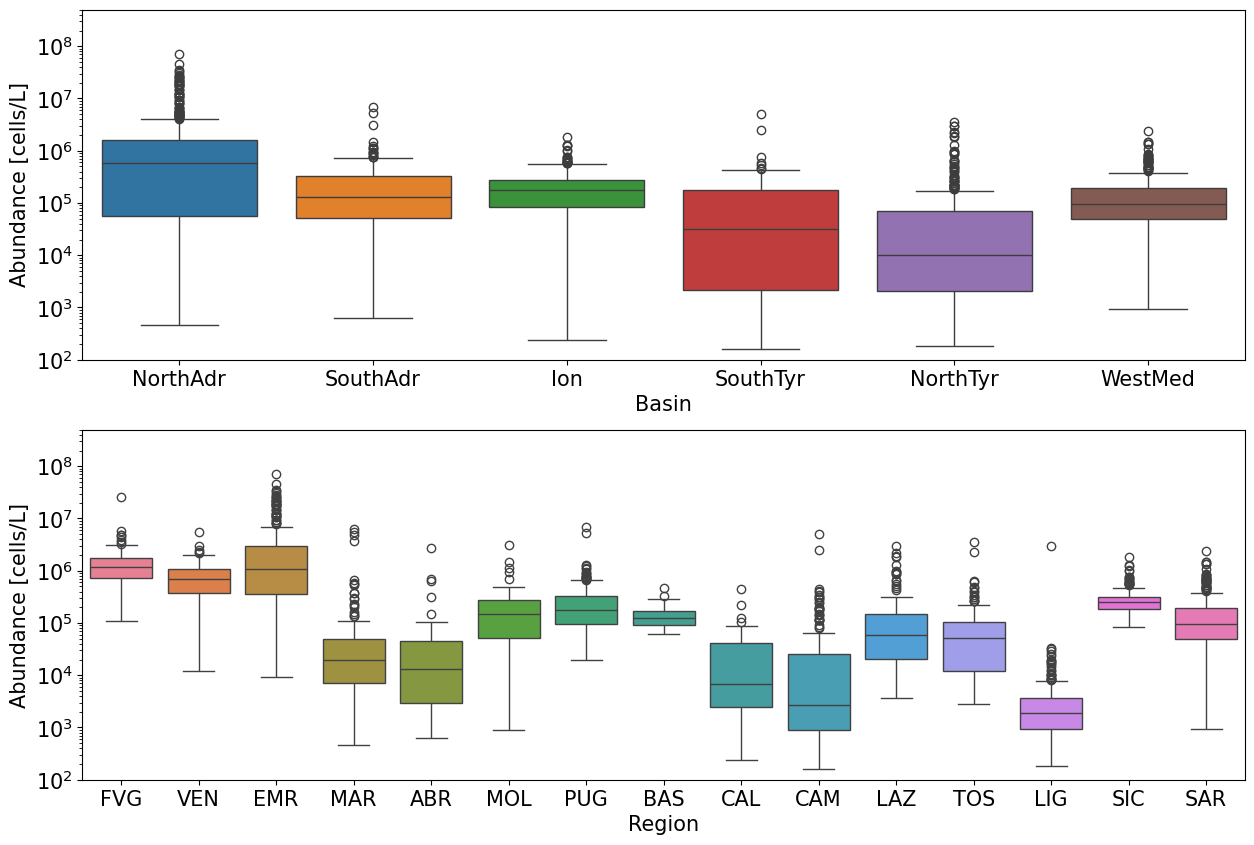

In [50]:
fig, axs = plt.subplots(2,1, figsize=(15, 10))
axs = axs.flatten()

abund = phyto_abund.groupby(["Date", "id"]).agg(
    {"Num_cell_l" : "sum", 
     "Basin" : "first",
     "Region" : "first"
     }
)

sns.boxplot(
    x = "Basin",
    y = "Num_cell_l",
    data = abund,
    hue = "Basin",
    ax = axs[0]
)
sns.boxplot(
    x = "Region",
    y = "Num_cell_l",
    data = abund,
    hue = "Region",
    ax = axs[1]
)
for ax in axs: 
    ax.set_yscale("log")
    ax.set_ylabel("Abundance [cells/L]", size = 15)
    ax.set_xticks(ax.get_xticks());
    ax.set_xticklabels(ax.get_xticklabels(), size = 15);
    ax.set_yticks(ax.get_yticks());
    ax.set_yticklabels(ax.get_yticklabels(), size = 15);
    ax.set_ylim(1e2, 5 * 1e8)
axs[0].set_xlabel("Basin", size = 15)
axs[1].set_xlabel("Region", size = 15)
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Abundance_per_basin.png", dpi = 300, bbox_inches = "tight")

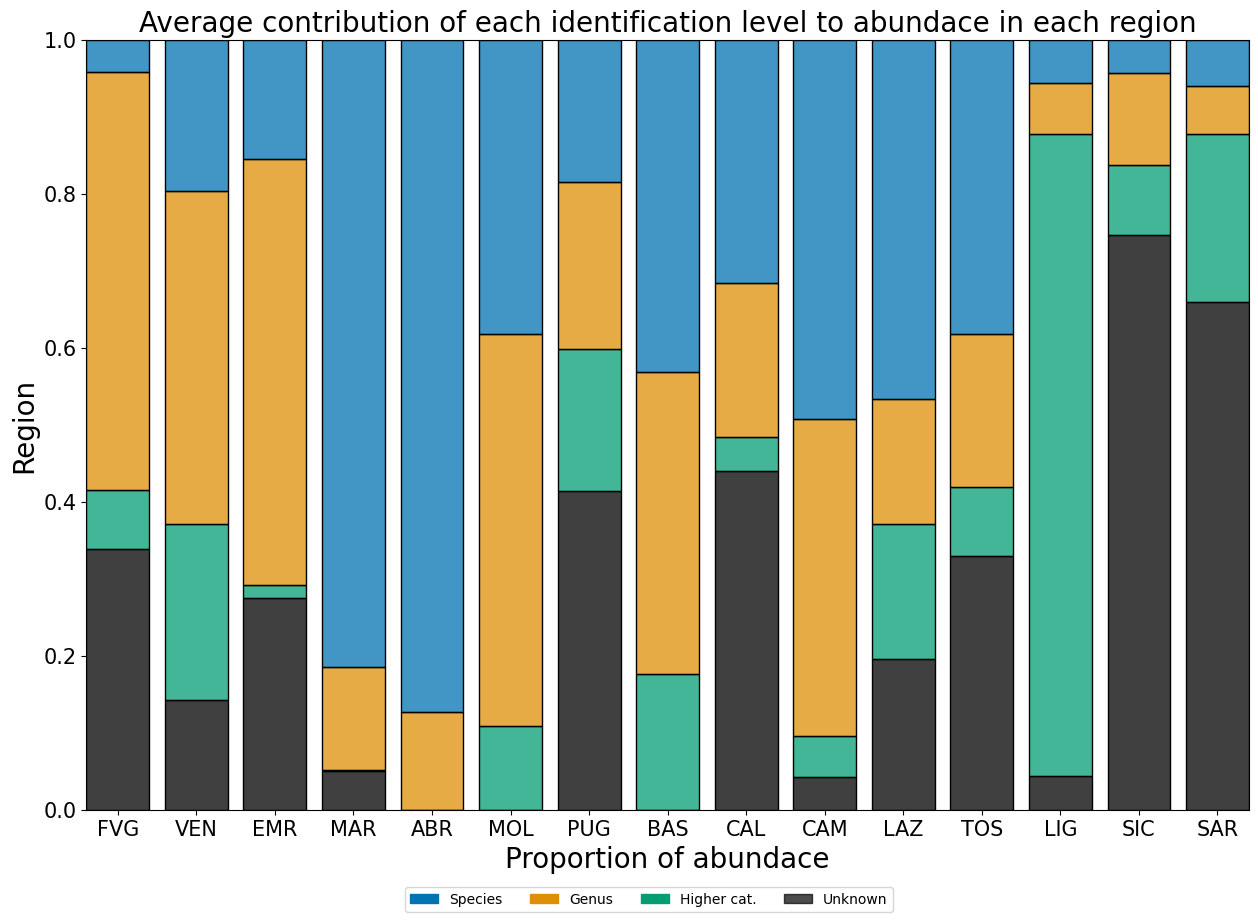

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
data = phyto_abund.groupby(["Date", "id", "Det_level"]).agg(
        {
            "Num_cell_l" : "sum", 
            "Region" : "first"
        }).reset_index().groupby(["Region", "Det_level"], observed = True).mean(numeric_only=True).reset_index().rename(columns={"Det_level" : "Identification level"})
data["Identification level"] = pd.Categorical(data["Identification level"], categories = ["Unknown", "Higher cat.", "Genus", "Species"][::-1], ordered = True)
num_colors = len(["Unknown", "Higher cat.", "Genus", "Species"])
colors = sns.color_palette("colorblind", num_colors)
colors[-1] = [0,0,0,0.7]#sns.color_palette("tab10", 4)[-1]
color_dict = {name: color for name, color in zip(["Unknown", "Higher cat.", "Genus", "Species"][::-1], colors)}
sns.histplot(
        data=data.sort_values(by="Identification level"),
        x="Region", hue="Identification level", weights="Num_cell_l",
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8, legend=False, palette=color_dict,
        ax = ax
    )
ax.set_xlabel("Proportion of abundace", size = 20)
ax.set_ylabel("Region", size = 20)
ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 15)
ax.set_yticks(ticks=ax.get_yticks(), labels = ax.get_yticklabels(), size = 15)
ax.set_title("Average contribution of each identification level to abundace in each region", size = 20)
handles, labels = ax.get_legend_handles_labels()
handles = [mpatches.Patch(color=color_dict[name], label=name) for i, name in enumerate(["Unknown", "Higher cat.", "Genus", "Species"][::-1])]
fig.legend(handles=handles, bbox_to_anchor=(0, -.03, 1, 0.101), loc='center', ncol=4)
plt.savefig("./average_proportion_cells_per_region_and_identification_level.png", bbox_inches="tight")

In [30]:
data.pivot_table(index = "Identification level", columns = "Region", fill_value=0, observed=True).apply(lambda x: x / sum(x), axis = 0)

Num_cell_l                                          \
Region                      FVG       VEN       EMR       MAR       ABR   
Identification level                                                      
Species                0.041078  0.195749  0.154576  0.813910  0.872155   
Genus                  0.543355  0.432863  0.552763  0.134066  0.127845   
Higher cat.            0.076586  0.228218  0.017861  0.001538  0.000000   
Unknown                0.338981  0.143170  0.274800  0.050485  0.000000   

                                                                        \
Region                     MOL       PUG       BAS       CAL       CAM   
Identification level                                                     
Species               0.382162  0.184617  0.430668  0.316037  0.492320   
Genus                 0.508360  0.216655  0.392368  0.200055  0.411228   
Higher cat.           0.109478  0.185024  0.176964  0.043289  0.053289   
Unknown               0.000000  0.413704  0.000000  0.440619  0.043164   

                                                                        
Region                     LAZ       TOS       LIG       SIC       SAR  
Identification level                                                    
Species               0.466068  0.381326  0.056393  0.043106  0.060318  
Genus                 0.162467  0.198686  0.065620  0.119607  0.061263  
Higher cat.           0.175290  0.090160  0.833582  0.090647  0.219260  
Unknown               0.196175  0.329828  0.044404  0.746640  0.659159

In [8]:
top_taxa = pd.read_csv("./Taxa_freq_95.csv")
top_species = pd.read_csv("./Species_freq_top.csv")
top_genera = pd.read_csv("./Genera_freq_top.csv")
top_classes = pd.read_csv("./Classes_freq_top.csv").dropna()

In [9]:
rich_classes = phyto_abund.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).reset_index()
rich_genera = phyto_abund.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Genus", "Taxon"]].groupby("Genus").nunique().sort_values("Taxon", ascending = False).reset_index()

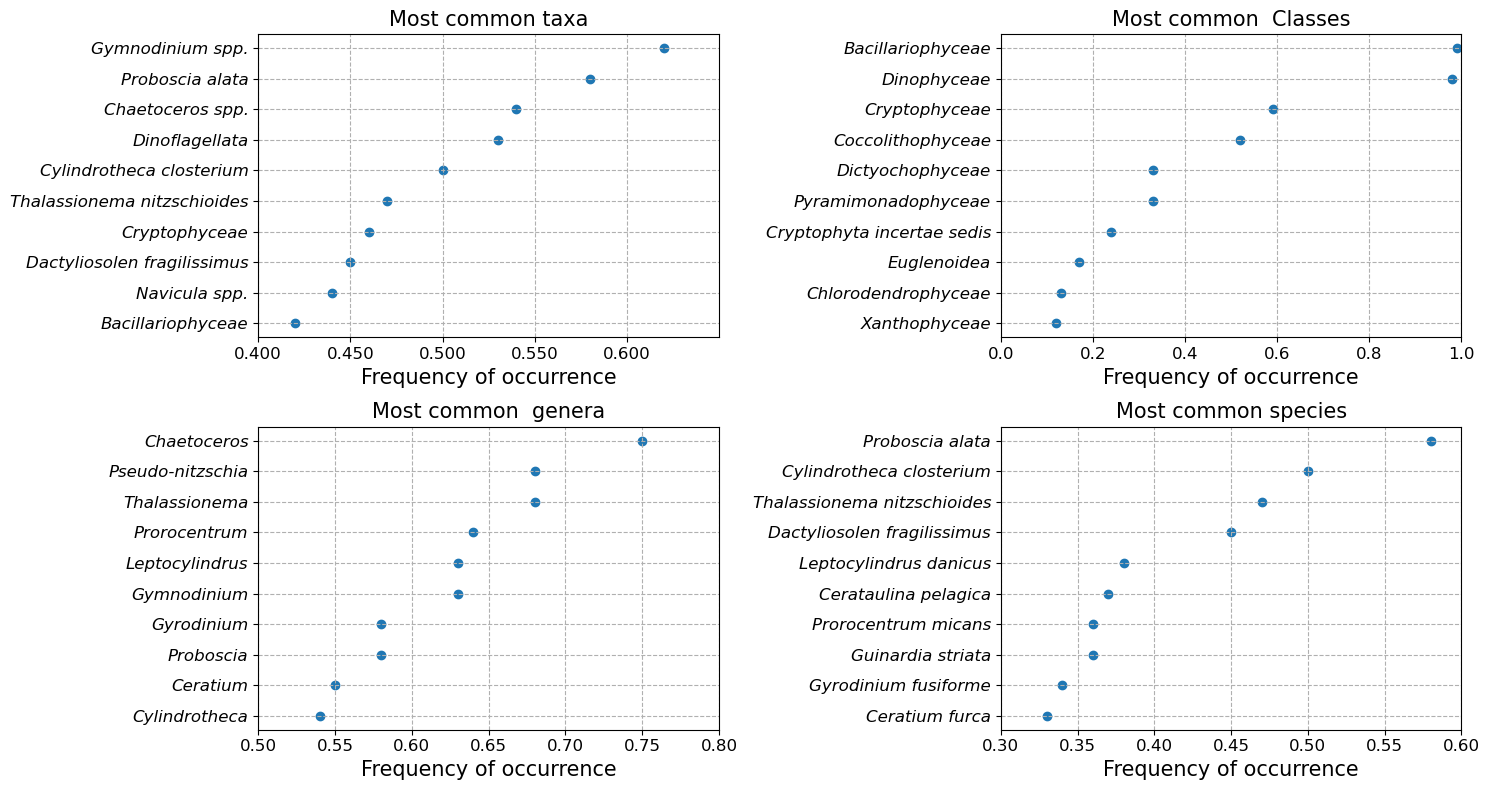

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

n_otu = 10
n_samples = 2220
for ax, data, title in zip(axs, 
                           [top_taxa, top_classes, top_genera, top_species], 
                           ["Most common taxa", "Most common  Classes", "Most common  genera", "Most common species"]
                           ):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(np.round(data.iloc[:n_otu,1].to_numpy() / n_samples, 2), ith_otu)
    ax.set_title(title, size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.grid(True, which='major', axis="both", linestyle='--')
    ax.set_xlabel("Frequency of occurrence", size = 15)
    
axs[0].set_xticks(ticks=axs[0].get_xticks()[:-1:2], labels = axs[0].get_xticklabels()[:-1:2], size = 12)
axs[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig("./most_common_taxa_classes_genera_species.png", bbox_inches="tight")

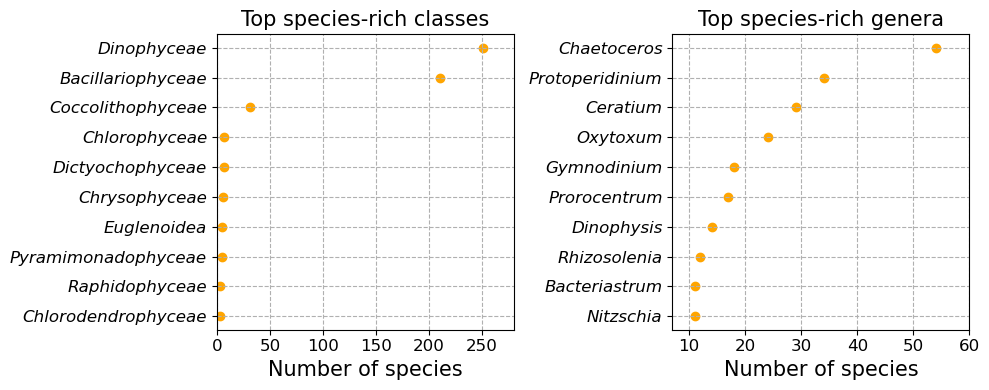

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

for ax, data, title in zip(axs, [rich_classes, rich_genera], ["Top species-rich classes", "Top species-rich genera"]):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(data.iloc[:n_otu,1].to_numpy(), ith_otu, color = "orange")
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.set_title(title, size = 15)
    ax.set_xlabel("Number of species", size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.grid(True, which='major', axis="both", linestyle='--')
axs[0].set_xlim(0,280)
axs[1].set_xlim(7,60)
plt.tight_layout()
plt.savefig("./top_species_rich_classes_genera.png", bbox_inches="tight")